In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.inspection import permutation_importance

In [ ]:
def plot_feature_importance(model, x_train, y_train):
    numeric_features     = ["Age", "Fare"]
    categorical_features = ["Pclass", "Sex", "Embarked"]
    
    # 랜덤 포레스트 모델 추출
    rf_model = model.named_steps['classifier']
    
    # 전처리된 데이터 가져오기
    x_preprocessed = model.named_steps['preprocessor'].transform(x_train)
    # print(x_preprocessed)
    
    # 피처 이름 가져오기
    ohe = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    feature_names = (
        numeric_features + 
        ohe.get_feature_names_out(categorical_features).tolist()
    )
    # print(feature_names)
    
    # 모델 내장 중요도
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # 순열 중요도 계산 (더 신뢰할 수 있는 중요도 측정)
    result = permutation_importance(
        rf_model, x_preprocessed, y_train, n_repeats=10, random_state=42
    )
    perm_importance = result.importances_mean
    perm_indices = np.argsort(perm_importance)[::-1]
    
    # 그래프 그리기
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    plt.title("Feature Importance (MDI)")
    plt.bar(range(x_preprocessed.shape[1]), importances[indices], align="center")
    plt.xticks(range(x_preprocessed.shape[1]), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    
    plt.subplot(2, 1, 2)
    plt.title("Feature Importance (Permutation)")
    plt.bar(range(x_preprocessed.shape[1]), perm_importance[perm_indices], align="center")
    plt.xticks(range(x_preprocessed.shape[1]), [feature_names[i] for i in perm_indices], rotation=90)
    plt.tight_layout()
    
    # plt.savefig('feature_importance.png')
    plt.show()


In [24]:
data_dir  = "/mnt/d/datasets/titanic"
data_path = os.path.join(data_dir, "train.csv")

df = pd.read_csv(data_path)
df = df.drop_duplicates(subset=['PassengerId', 'Name', 'Ticket'])

data = df.drop("Survived", axis=1)
targets = df["Survived"]

x_train, x_test, y_train, y_test = train_test_split(data, targets,
    test_size=0.2, random_state=42, stratify=targets)

numeric_features     = ["Age", "Fare"]
categorical_features = ["Pclass", "Sex", "Embarked"]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",   OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features),
])

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",   RandomForestClassifier(n_estimators=100, random_state=42)),
])
model.fit(x_train, y_train)

y_pred  = model.predict(x_test)
y_proba = model.predict_proba(x_test)[:, 1]
print(f">> Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f">> ROC AUC : {roc_auc_score(y_test, y_proba):.4f}")
print(">> Classification Report:\n", classification_report(y_test, y_pred))

>> Accuracy: 0.8212
>> ROC AUC : 0.8398
>> Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86       110
           1       0.78      0.74      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



[[-0.08113533  0.5138115   0.         ...  0.          0.
   1.        ]
 [-0.08113533 -0.66256323  0.         ...  0.          0.
   1.        ]
 [-0.08113533  3.95539858  1.         ...  0.          0.
   1.        ]
 ...
 [ 1.41700669  0.0532047   0.         ...  0.          0.
   1.        ]
 [ 1.34017889  0.13909685  1.         ...  0.          0.
   1.        ]
 [-0.08113533 -0.10973011  1.         ...  0.          0.
   1.        ]]
['Age', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']


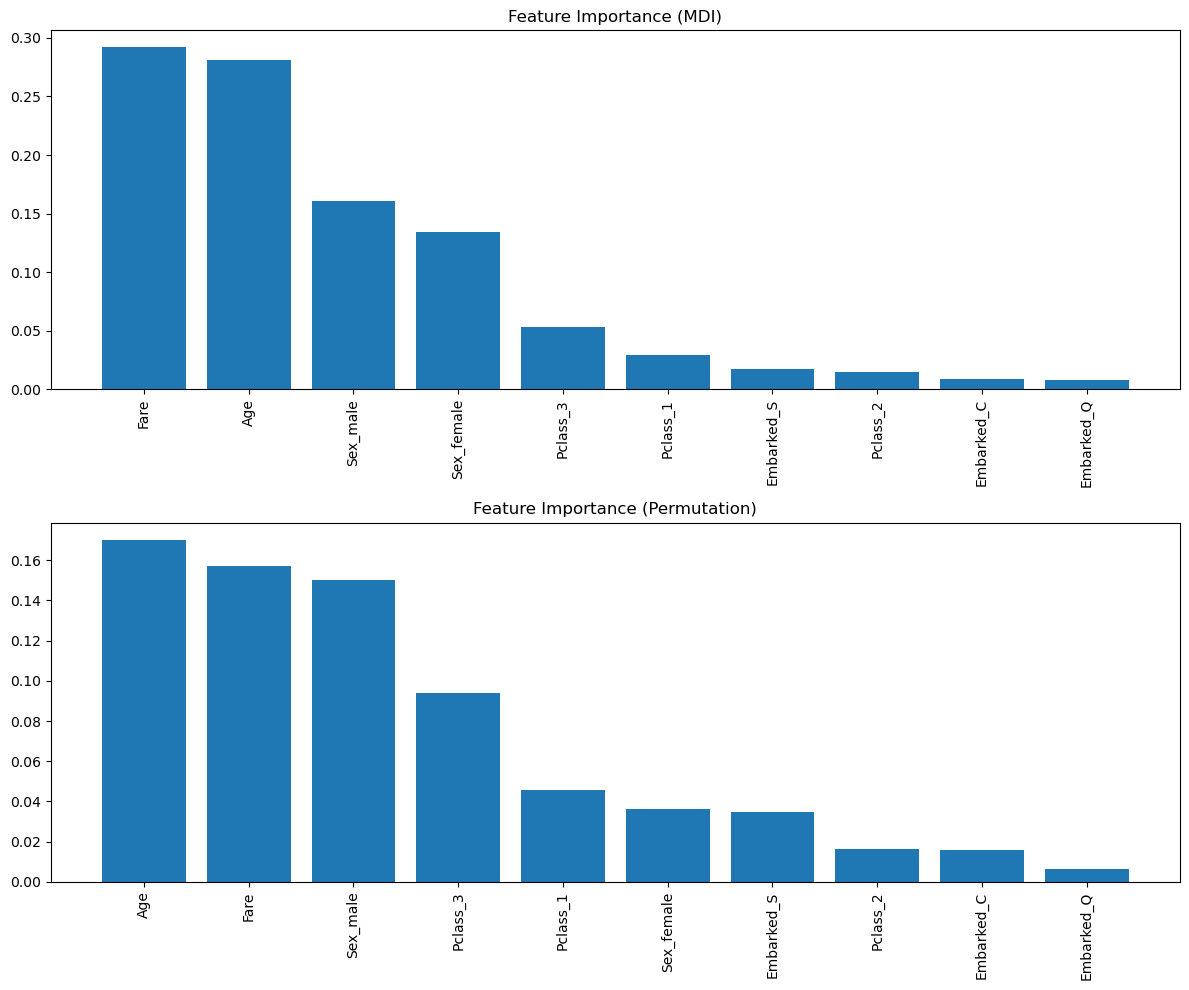

In [25]:
plot_feature_importance(model, x_train, y_train)